# Preprocessing

In [144]:
import os
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sn
warnings.filterwarnings('ignore')

##### Import data + artiste_note ###

In [106]:
#Import Data (all data) and data_by_artist
dfData=pd.read_csv("data.csv")
dataArtist=pd.read_csv("data_by_artist.csv",)
dataArtist=dataArtist[["artists","popularity"]]
#Merge artists with data
dfData["artists"]=dfData["artists"].str.replace("[","").str.replace("]","").str.replace("'",'').str.split(",")
dfData=dfData.explode("artists")
df=pd.merge(dfData,dataArtist,left_on="artists",right_on="artists")
df=df.rename(columns={"popularity_x":"popularity","popularity_y":"artistPop"})
df=df.drop_duplicates(subset=['id'])
data = df

##### Add a new column top 100 hits ### 

In [107]:
# DataSet des Top Hit (jusqu'à 2017)
top_songs = pd.read_csv("top_data.csv", encoding="iso-8859-1")

# On filtre donc notre DataSet de départ pour conserver seuelement les musiques avec date > 2017
data_2017 = data[data["year"]<2017]

# On recherche l'existence des musiques dans le DataSet des Hit Songs pour créer une nouvelle variable de succès 
data_2017["top"] = data_2017["name"].isin(top_songs["title"])
df=data_2017

##### Add a note for song names

In [108]:
name_good=pd.read_csv("name_grade.csv")
del name_good["Unnamed: 0"]
# df=df.rename(columns={"name_good_x":"popularity","name_good_y":"artistPop"})
df=pd.merge(df, name_good, how='inner', on=['name'])
df=df.drop_duplicates(subset=['id'])

##### Take only last n years of a dataFrame from a year

In [109]:
def split_df_by_year(df, range_max, year):
    """
        df : dataframe d'entrée
        step : range maximum d'annees que l'on veut pout notre dataset
        year : annnee de sortie de la musique à preédire
        Renvoie le dataframe respectant le range_max et l'annee
    """

    mask = (df['year'] <= year) & (df['year'] > year - range_max)
    current_df = df.loc[mask]
                
    return current_df
         
df = split_df_by_year(df, 5, 2015)

##### Creating train/test datasets

In [110]:
df.rename(columns={'energy':'Energy',"danceability":"Danceability","loudness":"Loudness(dB)","acousticness":"Acousticness",},inplace=True)

#oversampling 
# print('Original data shape %s' % Counter(y_train))
# sm = SMOTE()
# x_train, y_train = sm.fit_resample(x_train, y_train)
# print('Resampled data shape %s' % Counter(y_train))

#undersampling
# rus = RandomUnderSampler()
# print('Original data shape %s' % Counter(y_train))
# x_train, y_train = rus.fit_sample(x_train, y_train)
# print('Resampled data shape %s' % Counter(y_train))

## Apply a model now

In [111]:
df

,Acousticness,artists,Danceability,duration_ms,Energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,artistPop,top,name_good
5429,0.991000,Frédéric Chopin,0.314,199773,0.01570,0,1lOVilzLQuYY2fnFrQ76DK,0.91600,1,0.1340,...,"Waltz in C-Sharp Minor, Op. 64 No. 2",58,2012-09-14,0.0356,95.890,0.0939,2012,5.251931,False,1.000000
6139,0.992000,Frédéric Chopin,0.309,232240,0.04720,0,6qUjY7JsuQYxn99qfOAQyB,0.86600,3,0.0979,...,"Nocturne in E-Flat Major, Op. 9, No.2",54,2011-02-01,0.0410,72.915,0.0693,2011,5.251931,False,1.000000
7152,0.991000,Frédéric Chopin,0.334,241987,0.00732,0,64LTn5fTsPR0QLy7bVYl9w,0.95200,4,0.0968,...,"Nocturne No. 19 in E Minor, Op. 72, No. 1",59,2011-01-01,0.0355,60.171,0.0964,2011,5.251931,False,1.000000
7436,0.919000,Felix Mendelssohn,0.287,727787,0.14500,0,4Ivo07fh9EyPtPinrxXlC4,0.14400,4,0.0987,...,"Violin Concerto in E Minor, Op. 64, MWV O 14: ...",50,2011-01-01,0.0406,101.679,0.1670,2011,4.964286,False,1.000000
7559,0.993000,Franz Liszt,0.341,357747,0.01420,0,3GecLjGMqzjmgkvy2v41Wf,0.92100,2,0.1130,...,"Ständchen in D Minor (After Schubert), S. 560",55,2011-08-23,0.0388,76.382,0.0384,2011,11.911765,False,0.999710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341872,0.079600,Dawin,0.866,210893,0.73100,0,0mxoXsr14ILAYcXZBMJcOs,0.00000,6,0.0402,...,Dessert,57,2015-09-25,0.0407,97.030,0.7650,2015,57.000000,True,0.360520
341873,0.182000,Hot Flash Heat Wave,0.519,224714,0.80900,0,1sEzuZNasuG8s1OOHwYfN2,0.51000,1,0.0951,...,Gutter Girl,57,2015-09-11,0.0646,111.986,0.2840,2015,57.000000,False,0.823421
341874,0.076100,Jetta,0.459,189973,0.79600,0,6ce17pZwsMcYNab5IaC5MQ,0.00908,4,0.0633,...,I'd Love To Change The World - Matstubs Remix,66,2015-12-18,0.1320,139.913,0.2180,2015,66.000000,False,0.995065
341875,0.000559,It Looks Sad.,0.519,240640,0.72400,0,4GV9tK5QPaD3gVSJvMxUN0,0.00037,4,0.1200,...,Creature,56,2015-06-26,0.0303,135.051,0.4670,2015,56.000000,False,0.871221


In [112]:
# Create a function to encode the data
def one_encode_data(df,ctg_dict):
    # Work on a copy
    df_ = df.copy()
 
    # Encode categorical variable
    #scroll the ctg dict and get all categorical columns and thier possible values
    for k in ctg_dict:
        
        df_[k] = pd.Categorical(df_[k],
                               # Pandas categorical data type
                               # List possible values
                               categories=list(ctg_dict[k]))
    # Encode categorical variables
    return pd.get_dummies(df_)

In [113]:
def compute_metrics_(clf,test_set, true_v, rate):
    y_score = model_.predict_proba(test_set)
    y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred_).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    n_mtrc = tn /(tn+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    n_cmb_mtrc= 2 * (n_mtrc * Snsity_Rcll) / (n_mtrc + Snsity_Rcll)
    return Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc

In [114]:
def compute_metrics_dict(clf,test_set, true_v):
    y_pred=clf.predict(test_set)
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred,labels=[0,1]).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    n_mtrc = tn /(tn+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    n_cmb_mtrc= 2 * (n_mtrc * Snsity_Rcll) / (n_mtrc + Snsity_Rcll)
    y_score = clf.predict_proba(test_set)
    fpr, tpr, _ = roc_curve(true_v, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    return {'Accuracy':Arcy, 'Sensitivity_Recall':Snsity_Rcll, 'new_metric':n_mtrc, 'Specificity':Spcty, 'Precision':Prcs, 
            'F1_Score':F1_Score, 'new_cmb_score':n_cmb_mtrc,'AUC':roc_auc, 'model':clf}

In [115]:
df.columns

Index(['Acousticness', 'artists', 'Danceability', 'duration_ms', 'Energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'Loudness(dB)',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year', 'artistPop', 'top', 'name_good'],
      dtype='object')

In [116]:
target_df=df['top'].value_counts()
target_df_=pd.DataFrame(target_df)
target_df_["ratio"]=target_df_['top']*100/sum(target_df_['top'])
target_df_

,top,ratio
False,7349,74.69255
True,2490,25.30745


In [117]:
# Used variables for training 
Selected_var=['Acousticness', 'Danceability', 'duration_ms', 'Energy',
       'explicit', 'instrumentalness', 'key', 'liveness', 'Loudness(dB)',
       'mode', 'speechiness', 'tempo',
       'valence', 'year', 'artistPop', 'top', 'name_good']

In [118]:
df_sel = df[Selected_var]

In [119]:
ctg_names=["year","key"]

In [120]:
# convert object and int to categirical values for the specified columns name
#compute how many unique value on total
unique_ctg=[]
ctg_dict={}
for c in ctg_names:
    uniqu_c=list(df_sel[c].unique())
    ctg_dict[c]=list(df_sel[c].unique())
    unique_ctg=unique_ctg+uniqu_c

print("Total unique value is",len(unique_ctg))

Total unique value is 17


In [121]:
df_dum=encode_data(df_sel,ctg_dict)

In [122]:
df_dum.head()

,Acousticness,Danceability,duration_ms,Energy,explicit,instrumentalness,liveness,Loudness(dB),mode,speechiness,...,key_6,key_11,key_7,key_5,key_9,year_2012,year_2011,year_2015,year_2013,year_2014
5429,0.991,0.314,199773,0.01570,0,0.916,0.1340,-36.252,0,0.0356,...,0,0,0,0,0,1,0,0,0,0
6139,0.992,0.309,232240,0.04720,0,0.866,0.0979,-25.497,1,0.0410,...,0,0,0,0,0,0,1,0,0,0
7152,0.991,0.334,241987,0.00732,0,0.952,0.0968,-30.908,0,0.0355,...,0,0,0,0,0,0,1,0,0,0
7436,0.919,0.287,727787,0.14500,0,0.144,0.0987,-19.665,0,0.0406,...,0,0,0,0,0,0,1,0,0,0
7559,0.993,0.341,357747,0.01420,0,0.921,0.1130,-28.293,1,0.0388,...,0,0,0,0,0,0,1,0,0,0


In [123]:
top_values=df_dum['top'].values

In [124]:
df_dum=df_dum.drop(['top'], axis=1)

In [125]:
df_dum.columns

Index(['Acousticness', 'Danceability', 'duration_ms', 'Energy', 'explicit',
       'instrumentalness', 'liveness', 'Loudness(dB)', 'mode', 'speechiness',
       'tempo', 'valence', 'artistPop', 'name_good', 'key_1', 'key_3', 'key_4',
       'key_2', 'key_8', 'key_0', 'key_10', 'key_6', 'key_11', 'key_7',
       'key_5', 'key_9', 'year_2012', 'year_2011', 'year_2015', 'year_2013',
       'year_2014'],
      dtype='object')

In [126]:
dataset=df_dum.values

In [127]:
scaler = preprocessing.StandardScaler()
dataset_s=scaler.fit_transform(dataset)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(dataset_s, top_values, test_size=0.33)

In [129]:
Models_predictions=pd.DataFrame()
Models_predictions['y_ref']=y_test

## MLP classifier

In [187]:
from sklearn.neural_network import MLPClassifier

In [188]:
clf_MLP = MLPClassifier(random_state=1,hidden_layer_sizes=200, max_iter=1200)
clf_MLP.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=200, max_iter=1200, random_state=1)

Accuracy: 0.73
Sensitivity: 0.41
new_metric: 0.81
Specificity: 0.84
Precision: 0.46
f_1 Score: 0.43
new_comibned_score: 0.54


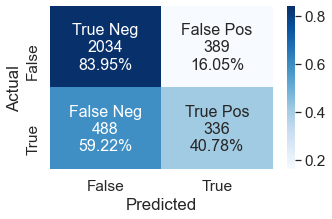

In [189]:
model_=clf_MLP
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

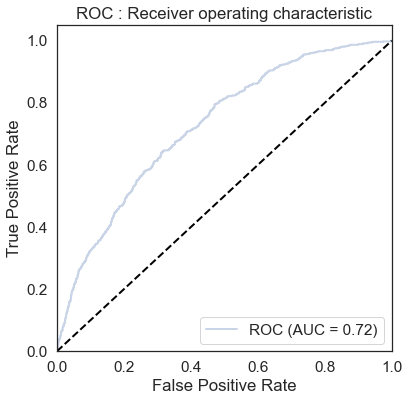

In [190]:
sn.set_style('white')
fig_auc, ax_auc = plt.subplots(1, 1, figsize=(6, 6))

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
ax_auc.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC (AUC = %0.2f)' % roc_auc)

ax_auc.plot([0,1],[0,1], linestyle='--', lw=2, color='black')
ax_auc.set_xlim([0.0, 1.0])
ax_auc.set_ylim([0.0, 1.05])
ax_auc.set_xlabel('False Positive Rate')
ax_auc.set_ylabel('True Positive Rate')
plt.title('ROC : Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [191]:
#Grid parameters
from sklearn.model_selection import ParameterGrid
import numpy as np
hidden_layer_sizes=[int(i) for i in np.linspace(1,500,3)]
activation=["identity", "logistic", "tanh", "relu"]
#activation=["relu"]
solver=["adam",'sgd','adam']
#alpha=np.linspace(0.00001,0.0001,4)

grid_dict={'hidden_layer_sizes':hidden_layer_sizes,'activation':activation,'solver':solver}
#MLP_Grids=
MLP_Grids=ParameterGrid(grid_dict)
print(len(MLP_Grids))

36


In [200]:
#Grid parameters
from sklearn.model_selection import ParameterGrid
hidden_layer_sizes=[int(i) for i in np.linspace(200,400,10)]
activation=["logistic"]
solver=['sgd']
#alpha=np.linspace(0.00001,0.0001,4)

grid_dict={'hidden_layer_sizes':hidden_layer_sizes,'activation':activation,'solver':solver}
#MLP_Grids=
MLP_Grids=ParameterGrid(grid_dict)
print(len(MLP_Grids))
# activation='logistic', hidden_layer_sizes=250, max_iter=1200,
#               solver='sgd'

10


In [164]:
model_.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 200,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

##### MLP - Hyper param tuning

In [201]:
from tqdm import tqdm
#progress bar 
model_list=[]
score_list=[]
# df for metrics souvgarde
df_merics_tune = pd.DataFrame(columns = ['Accuracy', 'Sensitivity_Recall', 'new_metric',
                                    'Specificity','Precision','F1_Score','new_cmb_score','AUC','model'])
for param in tqdm(list(MLP_Grids)):
    clf_MLP = MLPClassifier(max_iter=1200,random_state=1,**param)
    clf_MLP.fit(X_train, y_train)
    #model_list.append(clf_MLP)
    metrcis_dic_=compute_metrics_dict(clf_MLP, X_test, y_test)
#     print(clf_MLP.get_params())
    # append rows to an empty DataFrame
    df_merics_tune = df_merics_tune.append(metrcis_dic_,ignore_index = True)
    #score_list.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.81s/it]


In [205]:
df_merics_tune.iloc[2]

Accuracy                                                       0.764706
Sensitivity_Recall                                             0.217233
new_metric                                                     0.781282
Specificity                                                    0.950887
Precision                                                      0.600671
F1_Score                                                       0.319073
new_cmb_score                                                  0.339945
AUC                                                            0.761982
model                 MLPClassifier(activation='logistic', hidden_la...
Name: 2, dtype: object

## Best MLP model

In [267]:
clf_MLP = MLPClassifier(random_state=1,hidden_layer_sizes=244, max_iter=1200,activation='logistic', solver='sgd')
clf_MLP.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=244, max_iter=1200,
              random_state=1, solver='sgd')

Accuracy: 0.76
Sensitivity: 0.22
new_metric: 0.78
Specificity: 0.95
Precision: 0.6
f_1 Score: 0.32


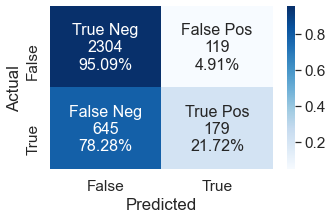

In [268]:
model_=clf_MLP
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [269]:
#save models prediction data
Models_predictions['Y_pred_MLP']=y_pred_
Models_predictions['Y_score_MLP']=y_score[:, 1]

## Stochastic Gradient Descent

In [259]:
from sklearn.linear_model import SGDClassifier

In [260]:
clf_SGDC =SGDClassifier(max_iter=1000, loss='log')

In [261]:
clf_SGDC.fit(X_train, y_train)

SGDClassifier(loss='log')

Accuracy: 0.75
Sensitivity: 0.31
new_metric: 0.79
Specificity: 0.89
Precision: 0.5
f_1 Score: 0.39


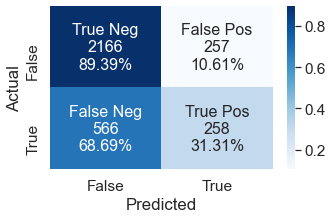

In [262]:
model_=clf_SGDC
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [263]:
#save models prediction data
Models_predictions['Y_pred_SGD']=y_pred_
Models_predictions['Y_score_SGD']=y_score[:, 1]

## XGB

In [252]:
from sklearn.ensemble import GradientBoostingClassifier

In [256]:
XGB = GradientBoostingClassifier(random_state=0)
# fit the model, 
XGB.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

Accuracy: 0.78
Sensitivity: 0.33
new_metric: 0.8
Specificity: 0.93
Precision: 0.61
f_1 Score: 0.43


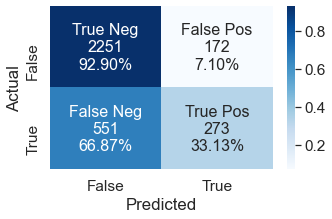

In [257]:
model_=XGB
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [258]:
Models_predictions['Y_pred_XGB']=y_pred_
Models_predictions['Y_score_XGB']=y_score[:, 1]

## Logistic Regression

In [249]:
from sklearn.linear_model import LogisticRegression
clf_LR = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

Accuracy: 0.77
Sensitivity: 0.26
new_metric: 0.79
Specificity: 0.94
Precision: 0.59
f_1 Score: 0.36


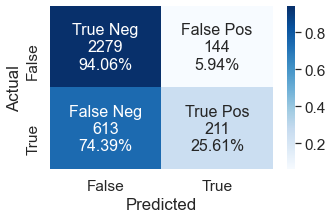

In [250]:
model_=clf_LR
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [251]:
Models_predictions['Y_pred_LR']=y_pred_
Models_predictions['Y_score_LR']=y_score[:, 1]

## KNN

In [236]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_subis, y_train_subis)
y_score = model_.predict_proba(X_test_subis)

Accuracy: 0.8
Sensitivity: 0.5
new_metric: 0.84
Specificity: 0.9
Precision: 0.63
f_1 Score: 0.56


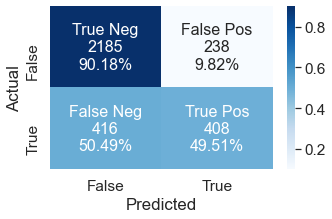

In [238]:
model_=neigh
rate=0.5
y_score = model_.predict_proba(X_test)
y_pred_=[1 if i>rate else 0 for i in y_score[:,1]]
cm = confusion_matrix(y_test,y_pred_)
#cm_pr=cm/cm.astype(np.float).sum(axis=1)
cm_pr=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_pr, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

Arcy, Snsity_Rcll, n_mtrc, Spcty, Prcs, F1_Score, n_cmb_mtrc = compute_metrics_(model_,X_test,y_test,rate)


print(f'Accuracy: {round(Arcy,2)}') 
print(f'Sensitivity: {round(Snsity_Rcll,2)}')
print(f'new_metric: {round(n_mtrc,2)}')
print(f'Specificity: {round(Spcty,2)}')
print(f'Precision: {round(Prcs,2)}')
print(f'f_1 Score: {round(F1_Score,2)}')

In [244]:
#save models prediction data
Models_predictions['Y_pred_KNN']=y_pred_
Models_predictions['Y_score_KNN']=y_score[:, 1]

In [275]:
Models_predictions

,y_ref,Y_pred_KNN,Y_score_KNN,Y_pred_LR,Y_score_LR,Y_pred_XGB,Y_score_XGB,Y_pred_SGD,Y_score_SGD,Y_pred_MLP,Y_score_MLP
0,False,0,0.00,0,0.13,0,0.17,0,0.13,0,0.15
1,True,1,1.00,0,0.47,0,0.33,0,0.45,0,0.45
2,True,0,0.33,0,0.31,0,0.41,0,0.38,0,0.33
3,False,0,0.33,0,0.25,1,0.58,0,0.29,0,0.25
4,False,0,0.00,0,0.19,0,0.23,0,0.11,0,0.18
...,...,...,...,...,...,...,...,...,...,...,...
3242,False,0,0.33,0,0.27,0,0.22,0,0.16,0,0.28
3243,True,0,0.33,0,0.41,0,0.20,0,0.21,0,0.39
3244,False,0,0.00,0,0.25,0,0.37,0,0.41,0,0.26
3245,False,0,0.00,0,0.18,0,0.29,0,0.08,0,0.18


In [271]:
# df for metrics souvgarde
df_modeles_merics = pd.DataFrame(columns = ['Accuracy', 'Sensitivity_Recall',
                                    'Specificity','Precision','F1_Score','AUC'])
models_name=["XGB","LR","MLP","SGD","KNN"]
true_v=Models_predictions["y_ref"].values
for m in models_name:
    y_pred_=Models_predictions["Y_pred_"+m].values
    y_score=Models_predictions["Y_score_"+m].values
    tn, fp, fn, tp = confusion_matrix(true_v,y_pred_).ravel()
    Arcy=(tp+tn)/(tn+fp+fn+tp)
    Snsity_Rcll=tp / (tp+fn)
    Spcty = tn / (tn + fp)
    Prcs = tp / (tp + fp)
    F1_Score = 2 * (Prcs * Snsity_Rcll) / (Prcs + Snsity_Rcll)
    fpr, tpr, _ = roc_curve(true_v, y_score)
    roc_auc = auc(fpr, tpr)
    metrics={'Accuracy':Arcy, 'Sensitivity_Recall':Snsity_Rcll, 'Specificity':Spcty, 'Precision':Prcs, 
            'F1_Score':F1_Score,'AUC':roc_auc}
    # append rows to an empty DataFrame 
    df_modeles_merics = df_modeles_merics.append(metrics, ignore_index=True)

#df_modeles_merics.set_index('Model')

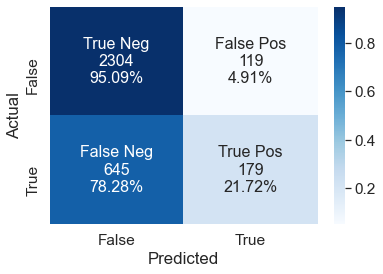

In [272]:
sn.set(font_scale=1.4)#for label size
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_pr.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sn.heatmap(df_cm, cmap="Blues", annot=labels,fmt="" ,annot_kws={"size": 16})# font size

In [273]:
pd.options.display.float_format = '{:,.2f}'.format

[Text(0, 0.5, 'XGB'),
 Text(0, 1.5, 'LR'),
 Text(0, 2.5, 'MLP'),
 Text(0, 3.5, 'SGD'),
 Text(0, 4.5, 'KNN')]

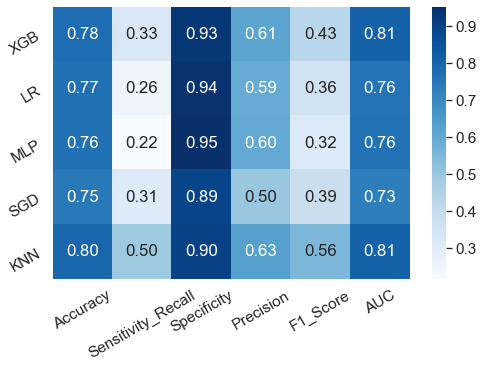

In [274]:
plt.figure(figsize = (8,5))
sn.set(font_scale=1.4) #for label size
heatmap=sn.heatmap(df_modeles_merics, cmap="Blues",annot=True, fmt=".2f",yticklabels=models_name)# font size
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=30) 